In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import pandas as pd
import seaborn as sns
import os
import json
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [76]:
# parse evaluation output file
def parse_output(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

        row_dict = {}
        for metric in lines[-2].split(','):
            split_line = metric.strip('\n').split(':')
            row_dict[split_line[0].strip()] = float(split_line[1].strip())

    return row_dict

gather = []
steps = [1] + [i for i in range(1, 200001) if i % 20000 == 0]

# Clap Baseline results
row_dict = parse_output(os.path.join('results/clap_baseline/audiosep_baseline'))
row_dict['Model'] = 'CLAP (Baseline)'

# duplicate baseline results for each time step for plotting purposes
for step in steps:
    print(step)
    row_dict['step'] = int(step)
    print(row_dict)
    gather.append(row_dict.copy())

# gather

1
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 1}
20000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 20000}
40000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 40000}
60000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 60000}
80000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 80000}
100000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 100000}
120000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 120000}
140000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 140000}
160000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 160000}
180000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.862, 'Model': 'CLAP (Baseline)', 'step': 180000}
200000
{'SDR': 5.708, 'SDRi': 5.673, 'SISDR': 3.

In [77]:
# For each checkpoint, al_retrieval checkpoint run
results_dir = './results/onepeace_al_retrieval_checkpoint'
slurm_output_dir = os.path.join(results_dir, 'validation_outputs/slurm_files')

for step in steps:
    file_path = os.path.join(slurm_output_dir, f'step={step}.ckpt_log.txt')
    row_dict = parse_output(file_path)
    row_dict['step'] = int(step)
    row_dict['Model'] = 'ONE-PEACE al_checkpoint'

    gather.append(row_dict)


In [78]:
df = pd.DataFrame(gather)
df.to_csv(os.path.join(results_dir, 'validation_results.csv'), index=False)

In [ ]:
df = pd.read_csv(os.path.join(results_dir, 'validation_results.csv'))

In [80]:
df.columns

Index(['SDR', 'SDRi', 'SISDR', 'Model', 'step'], dtype='object')

In [81]:
def line_plot(df, y, ax, x = 'step', hue = 'Model'):

    sns.lineplot(df, 
                 x=x, 
                 y = y,
                 hue = hue,  
                 marker='o',
                 ax = ax)

    texts = []
    # label points on the plot
    for x_val, y_val in zip(df[x], df[y]):
        texts.append(ax.text(x = x_val, 
                              y = y_val, 
                              s = f'{y_val:.2f}', 
                              color = 'blue'))
    
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
                ax = ax)
    

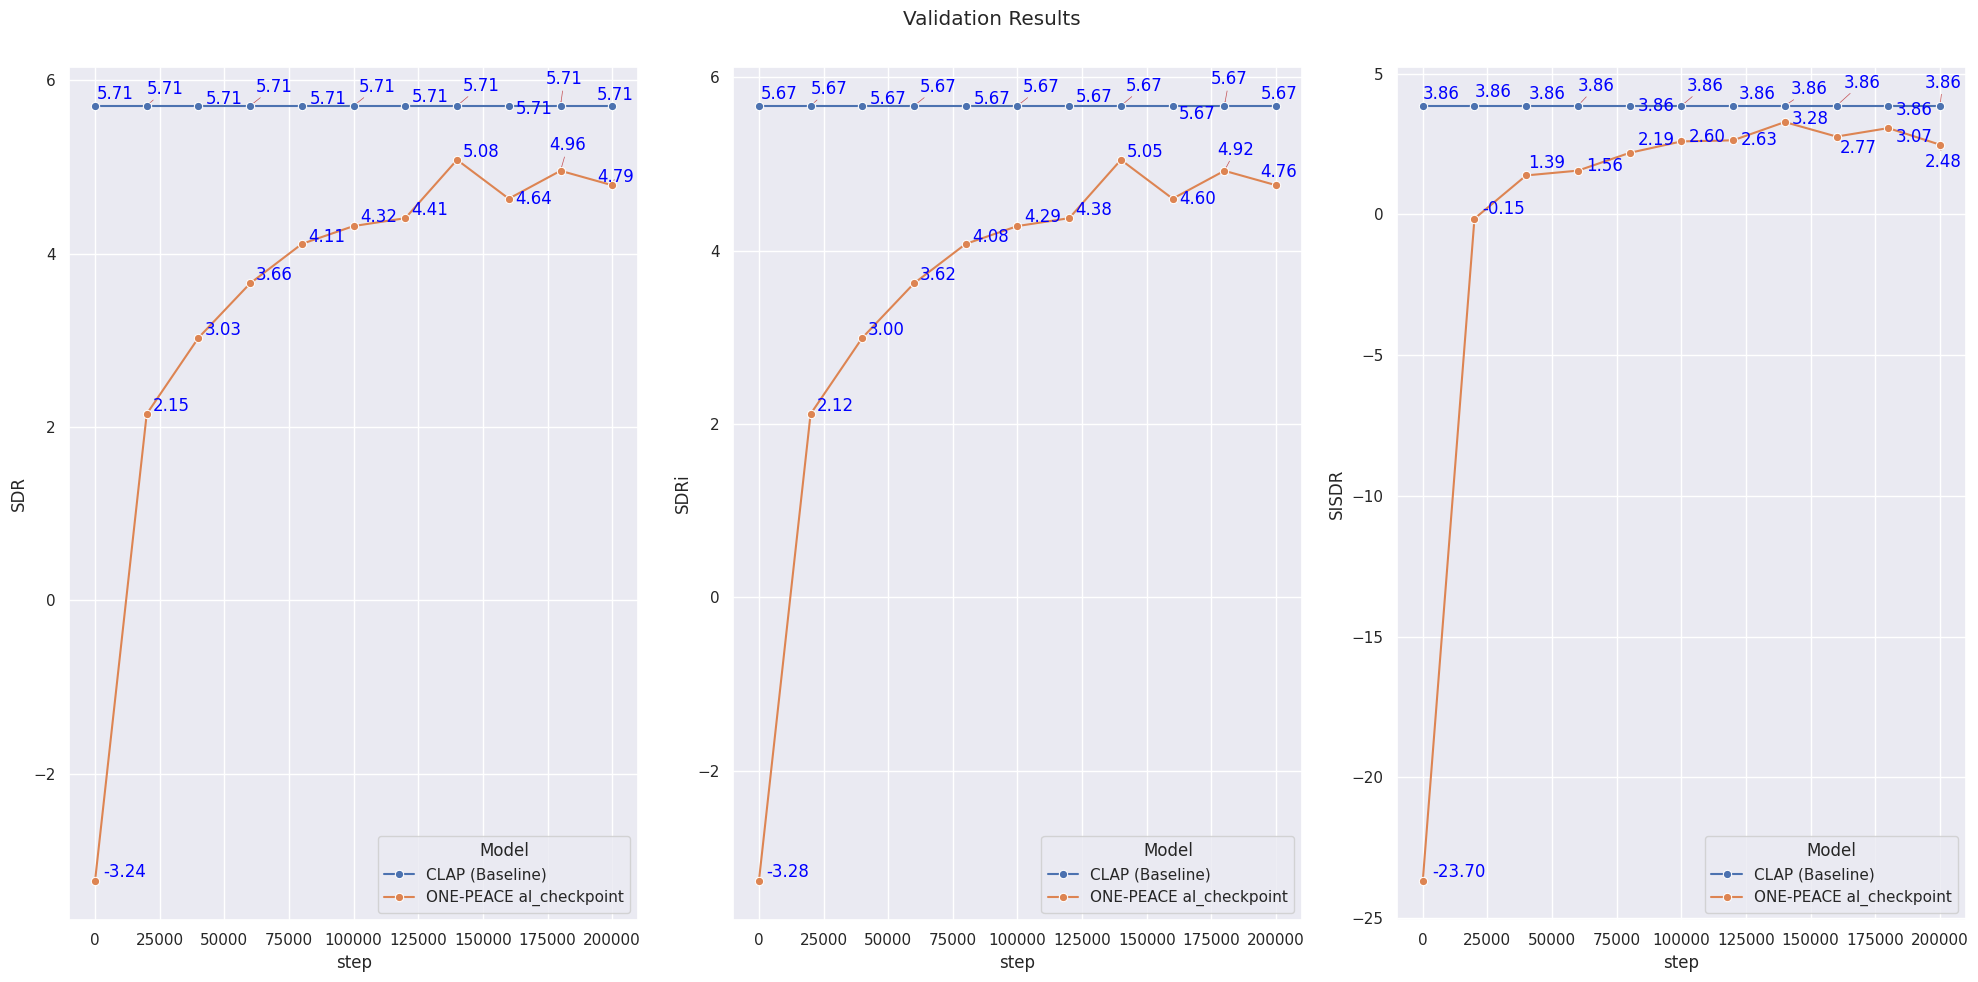

In [82]:
sns.set_theme()
fig, axes = plt.subplots(1,3, figsize = (20,10))

line_plot(df, 'SDR',   axes[0])
line_plot(df, 'SDRi',  axes[1])
line_plot(df, 'SISDR', axes[2])


plt.suptitle('Validation Results\n')
plt.tight_layout()